In [ ]:
import pandas as pd
import numpy as np
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from pixel_table import PixelTable
from tools import ProgressBarCounter
from pixel_table_image_handler import ImageHandler
from multiprocessing import Pool

In [ ]:
EL_SAUCE = EarthLocation(lat=-30.4726064*u.deg, lon=-70.7653747*u.deg, height=789*u.m)
utcoffset = -4*u.hour  # Chile
# time = Time('2018-6-13 07:26:12') #- utcoffset


In [ ]:
def load_catalog(path, time):
    alt_az_frame = AltAz(obstime=time,location=EL_SAUCE)
    raw_data = []
    header = ["star_name", "Vmag", "ra", "dec", "alt", "az", "astropy_coords", "astropy_altaz"]
    with open(path, "r", encoding="utf-8") as file:
        for line in file:
            if line.replace("\n","")[75:77] != "  ":
                star_name = line.replace("\n","")[4:14]
                RAh = line.replace("\n","")[75:77]
                RAm = line.replace("\n","")[77:79]
                RAs = line.replace("\n","")[79:83]
                DE_sign = line.replace("\n","")[83]
                DE_deg = line.replace("\n","")[84:86]
                DE_arcmin = line.replace("\n","")[86:88]
                DE_arcseg = line.replace("\n","")[88:90]
                Vmag = float(line.replace("\n","")[102:107])
                
                ra = '{}h{}m{}s'.format(RAh,RAm, RAs)
                dec = "{}{}d{}m{}s".format(DE_sign, DE_deg, DE_arcmin, DE_arcseg)
                c = SkyCoord(ra, dec, frame='icrs')
                c_altaz = c.transform_to(alt_az_frame)
                raw_data.append([star_name, Vmag, c.ra, c.dec, c_altaz.alt.value, c_altaz.az.value, c, c_altaz])
    data = pd.DataFrame(raw_data, columns = header)
    return data

In [ ]:
def data_to_ra_dec(data):
    ra = '{}h{}m{}s'.format(data.RAh,data.RAm, data.RAs)
    dec = "{}{}d{}m{}s".format(data.DE_sign, data.DE_deg, data.DE_arcmin, data.DE_arcseg)
    c = SkyCoord(ra, dec, frame='icrs')
    return c

In [ ]:
def data_by_date(time):
    data = load_like_dataframe("bsc5.dat")
    alt_az_frame = AltAz(obstime=time,location=EL_SAUCE)
    data_processed = data.apply(lambda x: pd.Series(
                                            [x.star_name, x.Vmag, x.ra, x.dec, x.coords.transform_to(alt_az_frame).alt.value,
                                                                                    x.coords.transform_to(alt_az_frame).az.value,
                                                                                    x.coords, x.coords.transform_to(alt_az_frame)]
                                                    , index=["star_name", "Vmag", "ra", "dec", "alt", "az", "astropy_coords", "astropy_altaz"]
                                                    ), axis=1)
    return data_processed

In [ ]:
df = load_catalog("bsc5.dat", Time("2019-9-07 04:00:56"))

In [ ]:
df_best =  df.query("alt > 20 and Vmag < 4").sort_values("Vmag")
df_best

In [ ]:
pixel_map = PixelTable("09-10-2019_05h10m24s_Interpolated_Data.pixtab")

In [ ]:
pixel_map.df.dropna().query("(49.7 <= az <= 50.1) and (54.8 <= alt <= 55.2)").sort_values("alt")

In [ ]:
best_alt_az = ((pixel_map.df.dropna().alt - df_best.iloc[0].alt).abs() + (pixel_map.df.dropna().az - df_best.iloc[0].az).abs())

In [ ]:
pixel_map.df.iloc[best_alt_az.idxmin()]

In [ ]:
def find_nearest_pixel(data, df_pixtab):
    best_alt_az = ((df_pixtab.dropna().alt - data.alt).abs()
                       + (df_pixtab.dropna().az - data.az).abs())
    return pixel_map.df.iloc[best_alt_az.idxmin()]

In [ ]:
find_nearest_pixel(df_best.iloc[0], pixel_map.df)

In [ ]:
df_best.iloc[0]

In [ ]:
def catalogue_on_pixtab(catalogue_df, df_pixtab):
    pb = ProgressBarCounter(catalogue_df.shape[0])
    pixtab_out = pd.DataFrame()
    for indx in catalogue_df.index:
        nearest_pixel = find_nearest_pixel(catalogue_df.loc[indx], df_pixtab)
        pixtab_out = pd.concat([pixtab_out, nearest_pixel], axis=0, ignore_index = True)
        pb.notify()
    return pixtab_out

In [ ]:
new_pix = catalogue_on_pixtab(df_best, pixel_map.df)

In [ ]:
preview = ImageHandler(new_pix)

In [ ]:
# def gen_worker_args(catalogue_df, df_pixtab, *args, **kwargs):
#     pbar = ProgressBarCounter(catalogue_df.shape[0])
#     for indx in catalogue_df.index:
#         yield (catalogue_df.loc[indx], df_pixtab, pbar)

In [ ]:
# def worker(args):
#     data, df_pixtab, pbar = args
#     nearest_pixel = find_nearest_pixel(data, df_pixtab)
#     pb.notify()
#     return nearest_pixel

In [ ]:
# p = Pool(10)
# pixel_list = p.map(worker, gen_worker_args(df_best, pixel_map.df))
# p.close()
# p.join()
# pixel_list = pd.concat(pixel_list, axis=1, ignore_index=True).transpose

In [ ]:
nearest_pixel1 = find_nearest_pixel(df_best.iloc[0], pixel_map.df).transpose()
nearest_pixel2 = find_nearest_pixel(df_best.iloc[1], pixel_map.df).transpose()

In [ ]:
pd.concat([nearest_pixel1, nearest_pixel2, nearest_pixel], axis=1, ignore_index=True).transpose()

In [ ]:
nearest_pixel

# Probando codigo

In [1]:
from catalog_handler import Catalog, CatalogPreview
from astropy.time import Time
from pixel_table import PixelTable

In [ ]:
catalog = Catalog("bsc5.dat", Time("2019-9-07 08:30:10"))

In [2]:
pixtab = PixelTable("09-10-2019_05h24m41s_Interpolated_Data_handcraft.pixtab")

In [ ]:
pixtab.preview.az


Creando vista previa de pixeles


In [ ]:
catalog.df

In [ ]:
catalog_pixtab = catalog.find_on_pixtab(pixtab.df)

In [ ]:
catalog_pixtab

In [ ]:
catalog_pixtab.to_csv("Brightest Stars 2019-9-07 08h30m10s Vmag-4 Alt-20.csv", index=False)

In [ ]:
preview = CatalogPreview(catalog_pixtab)

In [ ]:
preview.preview

In [ ]:
preview.save()

In [ ]:
pixtab.preview.save()

In [1]:
import numpy as np
from PIL import Image
from astropy.io import fits

In [2]:
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

Image size: 1548 x 1040


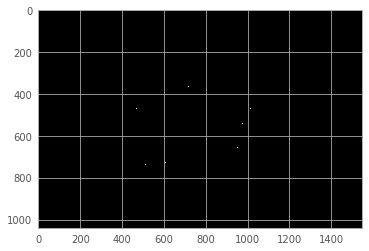

In [5]:
image = Image.open('results\\12-09-2019\\Brightest Stars 2019-9-07 08h30m10s Vmag-4 Alt-20.png')
xsize, ysize = image.size
print("Image size: {} x {}".format(xsize, ysize))
plt.imshow(image)

In [ ]:
r, g, b, s = image.split()
r_data = np.array(r.getdata()) # data is now an array of length ysize*xsize
g_data = np.array(g.getdata())
b_data = np.array(b.getdata())
print(r_data.shape)

In [ ]:
r_data = r_data.reshape(ysize, xsize)
g_data = g_data.reshape(ysize, xsize)
b_data = b_data.reshape(ysize, xsize)

In [ ]:
red = fits.PrimaryHDU(data=r_data)
red.header['LATOBS'] = "-30.4726064" # add spurious header info
red.header['LONGOBS'] = "-70.7653747"
red.header['TIME'] = "2019-9-07 08:30:10"
red.writeto('red.fits')

green = fits.PrimaryHDU(data=g_data)
green.header['LATOBS'] = "-30.4726064" # add spurious header info
green.header['LONGOBS'] = "-70.7653747"
green.header['TIME'] = "2019-9-07 08:30:10"
green.writeto('green.fits')

blue = fits.PrimaryHDU(data=b_data)
blue.header['LATOBS'] = "-30.4726064" # add spurious header info
blue.header['LONGOBS'] = "-70.7653747"
blue.header['TIME'] = "2019-9-07 08:30:10"
blue.writeto('blue.fits')